In [3]:
!unzip -nq /content/chair_all.zip -d data # terminal command to unzip dataset

In [4]:
import torch
import numpy as np
import time
import torch.optim as optim
from tqdm import tqdm, trange
import utils
import models


In [5]:
cube_len = 32
epoch_count = 400
batch_size = 128
noise_size = 200
d_lr = 0.00005 # discriminator learning rate
g_lr = 0.0025 # generator learning rate
log_folder = "logs/"

condition_count = 2

In [6]:
from torch.utils.data import TensorDataset, DataLoader

all_models1 = utils.load_all("/content/data/chair_all/", contains = '_1.mat') # names ends with a rotation number for 12 rotations, 30 degrees each
all_models7 = utils.load_all("/content/data/chair_all/", contains = '_7.mat') # 1 and 7 are 0 and 180 degrees respectively

train_set1 = torch.from_numpy(all_models1).float()
train_set7 = torch.from_numpy(all_models7).float()

train_set_all = TensorDataset(train_set1, train_set7)
train_loader = DataLoader(dataset=train_set_all, batch_size=batch_size, shuffle=True, pin_memory=True)

In [7]:
device = torch.device("cuda:0")

generator = models.Generator(noise_size=(noise_size + 1), cube_resolution=cube_len) # noise size +1 condition value
discriminator = models.Discriminator(cube_resolution=cube_len)

generator = generator.to(device)
discriminator = discriminator.to(device)

In [8]:
optimizerD = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))

In [9]:

class CustomHybridLoss(torch.nn.Module):
    def __init__(self, bce_weight=0.5, l1_weight=0.5):
        super(CustomHybridLoss, self).__init__()
        self.bce_weight = bce_weight
        self.l1_weight = l1_weight
        self.bce_loss = torch.nn.BCELoss()
        self.BCEWithLogitsLoss = torch.nn.BCEWithLogitsLoss()

    def forward(self, predictions, targets, ):
        bce = self.bce_loss(predictions, targets)
        l1 = self.BCEWithLogitsLoss(predictions, targets)
        return self.bce_weight * bce + self.l1_weight * l1

In [10]:
from torch.autograd import Variable
criterion_GAN = CustomHybridLoss(bce_weight=0.7, l1_weight=0.3)

def get_gan_loss(tensor,ones):
    if(ones):
        return criterion_GAN(tensor,Variable(torch.ones_like(tensor.data).to(device), requires_grad=False))
    else:
        return criterion_GAN(tensor,Variable(torch.zeros_like(tensor.data).to(device), requires_grad=False))

In [11]:
def get_noise(b_size = batch_size):
    return torch.randn([b_size,noise_size], device=device)

In [12]:
def train_GAN_epoch():

    g_loss = []
    d_loss = []
    gen_out = []
    train_disc = True

    for i, data_c in enumerate(train_loader):

        acc_list = []

        for c in range(condition_count): # train GAN for each condition

            data = data_c[c].to(device)

            discriminator.zero_grad()
            Dr_output = discriminator(data, c)
            errD_real = get_gan_loss(Dr_output,True)

            fake = generator(get_noise(data.shape[0]), c)
            Df_output = discriminator(fake.detach(), c)
            errD_fake = get_gan_loss(Df_output,False)

            errD = errD_real + errD_fake

            acc_r = Dr_output.mean().item()
            acc_f = 1.0 - Df_output.mean().item()
            acc = (acc_r + acc_f) / 2.0

            acc_list.append(acc) # calculate discriminator accuracy

            if (train_disc): # train discriminator if the last batch accuracy is less than 0.95
                errD.backward()
                optimizerD.step()

            generator.zero_grad() # train generator
            fake = generator(get_noise(), c)
            DGF_output = discriminator(fake, c)
            errG = get_gan_loss(DGF_output,True)
            errG.backward()
            optimizerG.step()

            d_loss.append(errD.mean().item())
            g_loss.append(errG.mean().item())

        generator.zero_grad() # train generator for combined loss
        discriminator.zero_grad()

        fix_noise = get_noise()

        fake0 = generator(fix_noise, 0) # generate for condition 0 and 1
        fake1 = generator(fix_noise, 1)

        fake1_rot = torch.rot90(fake1, 2, [1, 2]) # rotate condition 1
        fake_combined = (fake0 + fake1_rot) / 2.0 # combine them by averaging

        DGF_output_c = discriminator(fake_combined, 0) # train generator for combined output
        errG_c = get_gan_loss(DGF_output_c,True)
        errG_c.backward()
        optimizerG.step()

        train_disc = np.mean(acc_list) < 0.95 # decide for the next batch

    gen_out.append( fake0.detach().cpu() ) # return generated samples for condition 0, 1 and combined
    gen_out.append( fake1.detach().cpu() )
    gen_out.append( fake_combined.detach().cpu() )

    return np.mean(d_loss), np.mean(g_loss) , gen_out

In [13]:
utils.clear_folder(log_folder) # create log folder
log_file = open(log_folder +"logs.txt" ,"a") # open log file

In [14]:
d_list = []
g_list = []

pbar = tqdm( range(epoch_count+1) )
for i in pbar :

    startTime = time.time()

    d_loss, g_loss, gen = train_GAN_epoch() #train GAN for 1 epoch

    d_list.append(d_loss) # get discriminator and generator loss
    g_list.append(g_loss)

    utils.plot_graph([d_list,g_list], log_folder + "loss_graph") # plot loss graph up to that epoch

    epoch_time = time.time() - startTime

    writeString = "epoch %d --> d_loss:%0.3f g_loss:%0.3f time:%0.3f" % (i, d_loss, g_loss, epoch_time) # generate log string

    pbar.set_description(writeString)
    log_file.write(writeString + "\n") # write to log file
    log_file.flush()

    if(i%10 == 0): # save generated samples for each 10th epoch because it takes a long time to visualize the samples
        utils.visualize_all(gen, save=True, name = log_folder + "samples_epoch" + str(i))

epoch 400 --> d_loss:0.480 g_loss:2.200 time:7.499: 100%|██████████| 401/401 [1:29:04<00:00, 13.33s/it]


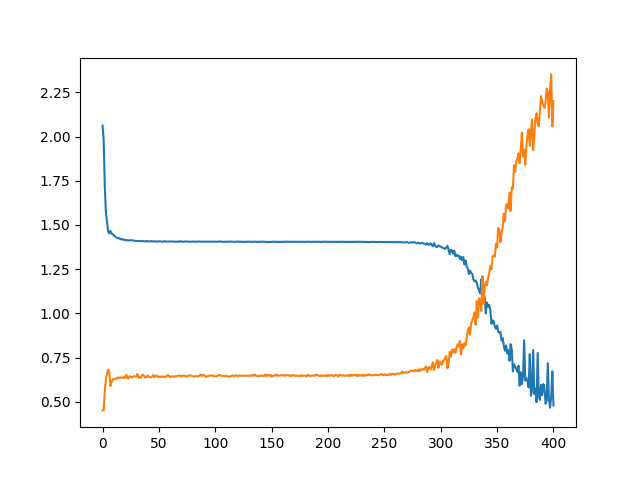

In [15]:
from PIL import Image

# Open the image
img = Image.open('/content/logs/loss_graph.png')

# Display the image
img

In [16]:
from PIL import Image

# Open the image
img = Image.open('/content/logs/samples_epoch400.png')

# Display the image
img.show()

In [17]:
file_path = '/content/logs/logs.txt'

try:
    with open(file_path, 'r') as file:
        file_lines = file.readlines()
        print("File Content:")
        for line in file_lines:
            print(line.strip())
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


File Content:
epoch 0 --> d_loss:2.062 g_loss:0.452 time:8.517
epoch 1 --> d_loss:1.981 g_loss:0.452 time:7.245
epoch 2 --> d_loss:1.713 g_loss:0.558 time:7.223
epoch 3 --> d_loss:1.571 g_loss:0.630 time:7.233
epoch 4 --> d_loss:1.512 g_loss:0.658 time:7.418
epoch 5 --> d_loss:1.465 g_loss:0.683 time:7.354
epoch 6 --> d_loss:1.452 g_loss:0.668 time:7.422
epoch 7 --> d_loss:1.466 g_loss:0.589 time:7.481
epoch 8 --> d_loss:1.453 g_loss:0.611 time:7.527
epoch 9 --> d_loss:1.448 g_loss:0.626 time:7.632
epoch 10 --> d_loss:1.441 g_loss:0.630 time:7.665
epoch 11 --> d_loss:1.436 g_loss:0.629 time:7.563
epoch 12 --> d_loss:1.430 g_loss:0.633 time:7.541
epoch 13 --> d_loss:1.427 g_loss:0.632 time:7.641
epoch 14 --> d_loss:1.427 g_loss:0.639 time:7.734
epoch 15 --> d_loss:1.424 g_loss:0.634 time:7.694
epoch 16 --> d_loss:1.419 g_loss:0.638 time:7.659
epoch 17 --> d_loss:1.421 g_loss:0.637 time:7.574
epoch 18 --> d_loss:1.418 g_loss:0.635 time:7.540
epoch 19 --> d_loss:1.415 g_loss:0.640 time:7.